# Домашнее задание по теме «Элементарные методы анализа временных рядов»


## Вводная часть

**Задание**

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2. Приблизьте оба варианта моделями из класса MA.
3. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

from google.colab import files


In [19]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [20]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [2]:
from google.colab import files
uploaded = files.upload()

Saving monthly-car-sales-in-quebec-1960.csv to monthly-car-sales-in-quebec-1960.csv


In [18]:
car_sales_in_quebec = pd.read_csv("/content/monthly-car-sales-in-quebec-1960.csv")

# не стационарный ряд
original_series = car_sales_in_quebec["Count"].copy()  

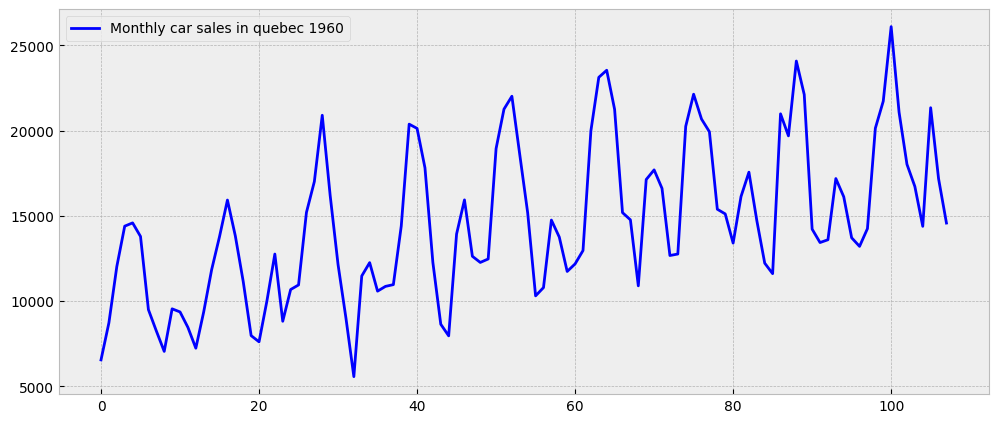

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 5))
    plt.plot(car_sales_in_quebec["Count"], color='blue',label='Monthly car sales in quebec 1960')
    plt.legend()

Из прошлого Домашнего задания мы уже знаем, что для приведения этого временного ряда в стационарный вид необходимо провести следующие преобразования:
1. Снижаем дисперсию с помощью преобразования Бокса-Кокса
2. Убираем тренд
3. Убираем сезонность

In [21]:
transform_series = boxcox(car_sales_in_quebec["Count"], 0)
transform_series = transform_series[1:] - transform_series[:-1]
transform_series = transform_series[12:] - transform_series[:-12]


Results of Dickey-Fuller Test:
Test Statistic                 -3.516067
p-value                         0.007584
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


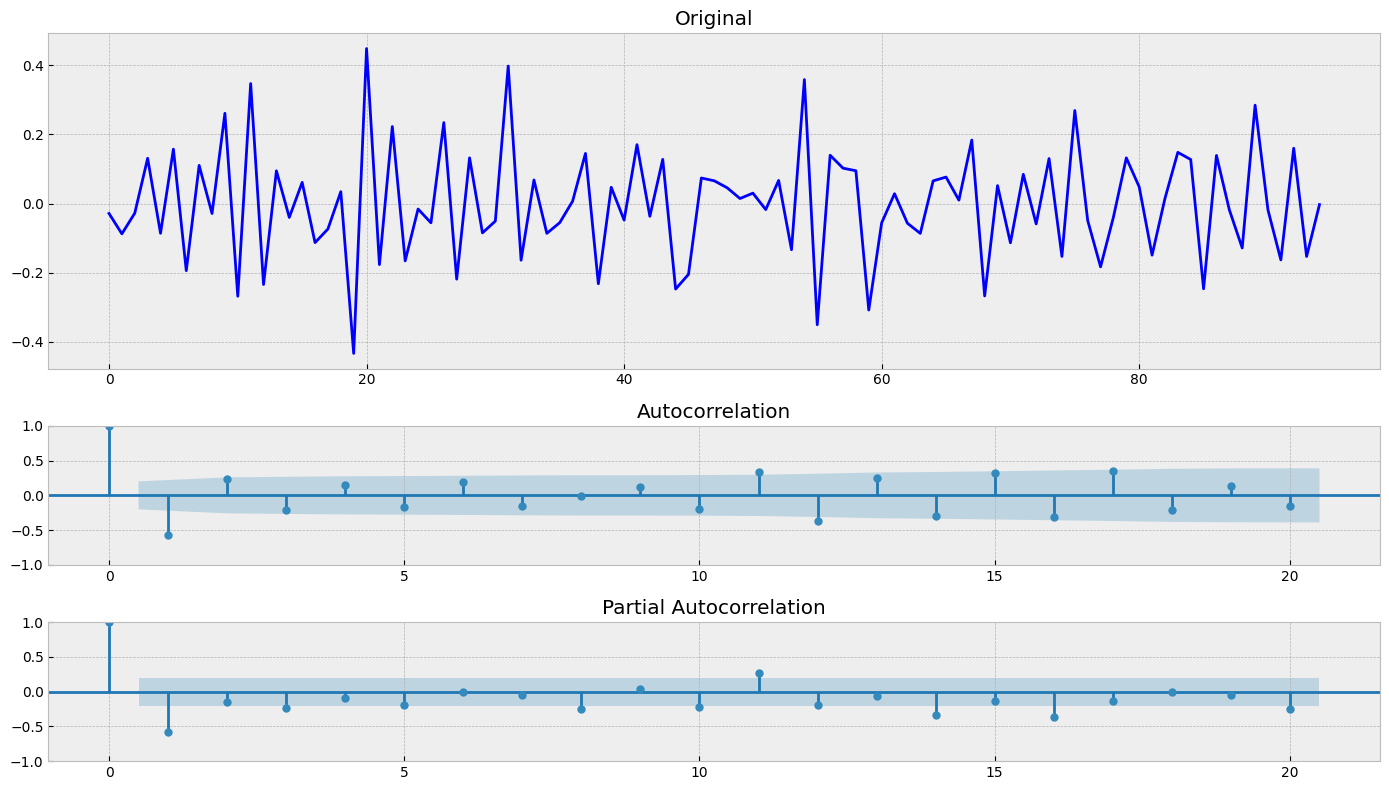

In [24]:
tsplot(transform_series)

**Тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда**

Теперь у нас есть два временных ряда: нестационарный original_series и стационарный transform_series. Далее необходимо приблизить оба варианта моделями из класса MA. 

Для не стационарного ряда применим метод Хольта-Винтерса (TEMA), т.к. данный метод лучше подходит для временных рядов имеющих тренд и сезонность, а нам известно что наш ряд содержит указанные компоненты.

Для стационарного ряда можно использовать скользящее среднее (MA), взвешенное скользящее среднее (WMA) или экспоненциальное сглаживание (EMA). Поскольку стационарный ряд по определению не содержит тренда и сезонности, такие методы как двойное и тройное экспоненциальное сглаживание в данном случае применять не имеет смысла.

In [26]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [27]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [28]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

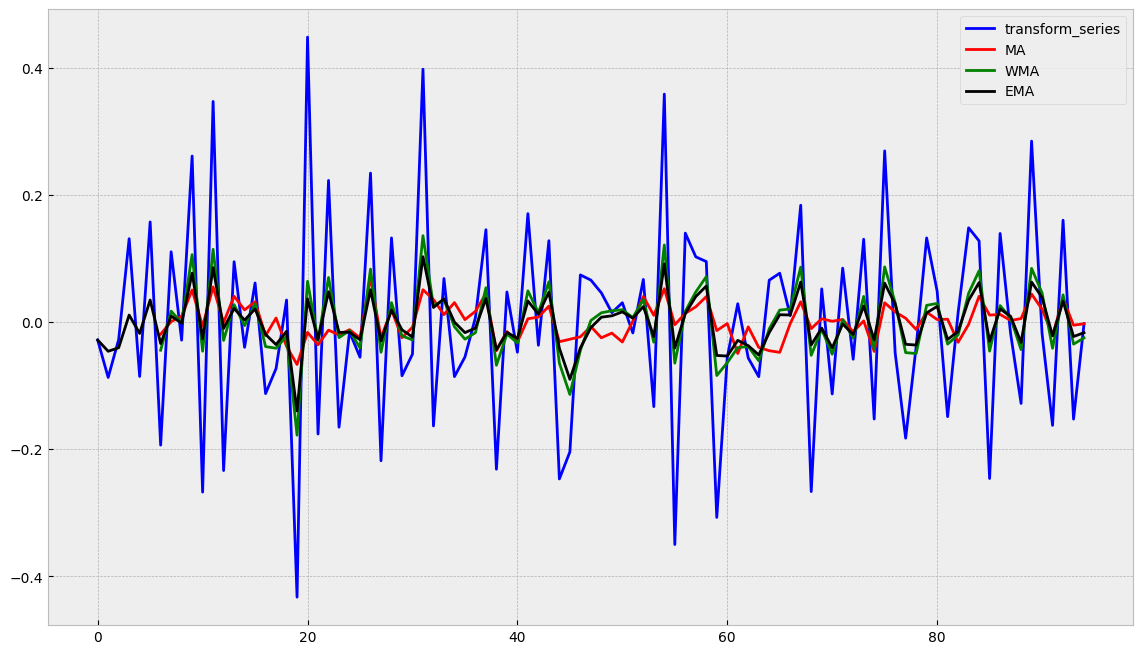

In [47]:
window = 7
ema = exponential_moving_average(transform_series, 0.3)
wma = weighted_moving_average(transform_series, window, [1,1,2,3,5,8,13])
ma = moving_average(transform_series, window)
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(transform_series, color='blue',label='transform_series')
    plt.plot(ma, color='red', linewidth='2', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='2', label='EMA')
    plt.legend()

По графикам видно что MA апроксимирует данные хуже других методов, взвешенное WMA и EMA визуально имеют схожие результаты, но WMA чуть точнее ловит пики графика. Это связано с тем что WMA в отличие от EMA  учитывает только данные предыдущих 7 точек.

In [53]:
from sklearn.metrics import mean_squared_error
MSE_MA = mean_squared_error(transform_series[window-1:], ma[window-1:])
MSE_WMA = mean_squared_error(transform_series[window-1:], wma[window-1:])
MSE_EMA = mean_squared_error(transform_series[window-1:], ema[window-1:])

print(f'MSE_MA: {MSE_MA} MSE_wMA: {MSE_WMA} MSE_EMA: {MSE_EMA}')

MSE_MA: 0.024059137775988282 MSE_wMA: 0.015350692681922297 MSE_EMA: 0.018727505226582387


Предыдущий вывод можно подтвердить определив величину среднеквадратического отклонения каждого из методов MA

In [63]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [70]:
def plot_dema(alpha, beta):
    dema = double_ema(original_series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(original_series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

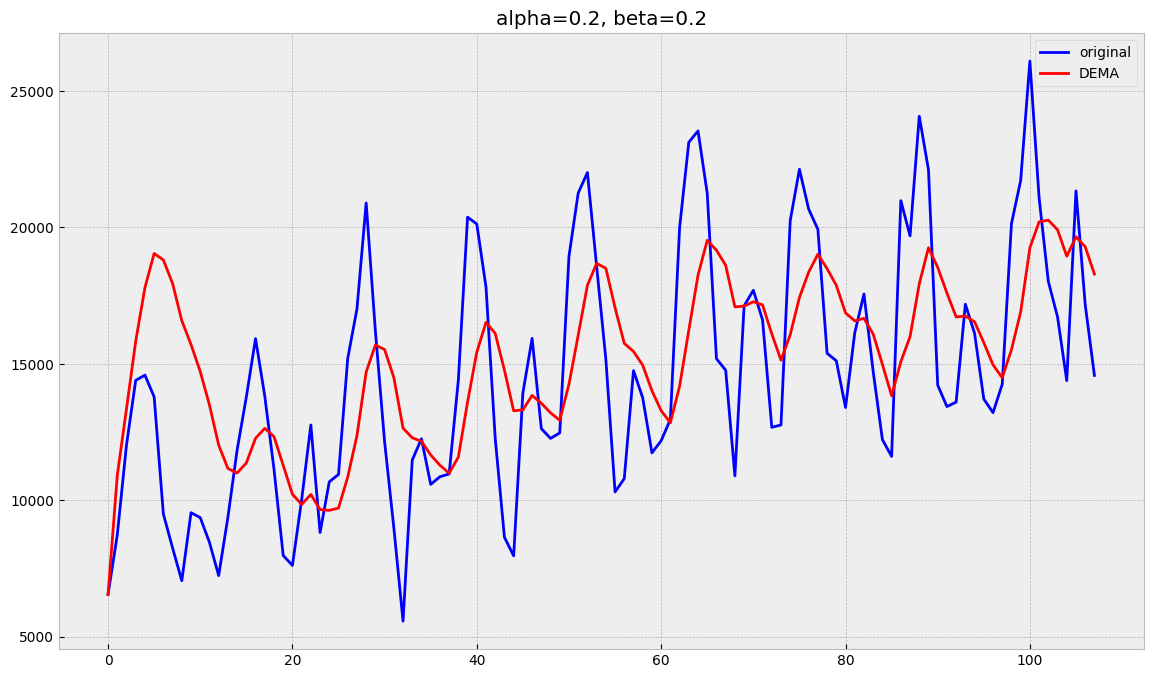

In [71]:
plot_dema(0.2, 0.2)

In [99]:
def initial_trend(series, season_len):
  sum = 0.0
  for i in range(season_len):
    sum += float(series[i+season_len] - series[i]) / season_len
  return sum / season_len

In [100]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [101]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [108]:
def plot_tema(alpha, beta, gamma, ser=original_series, ser_to_plot=original_series, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

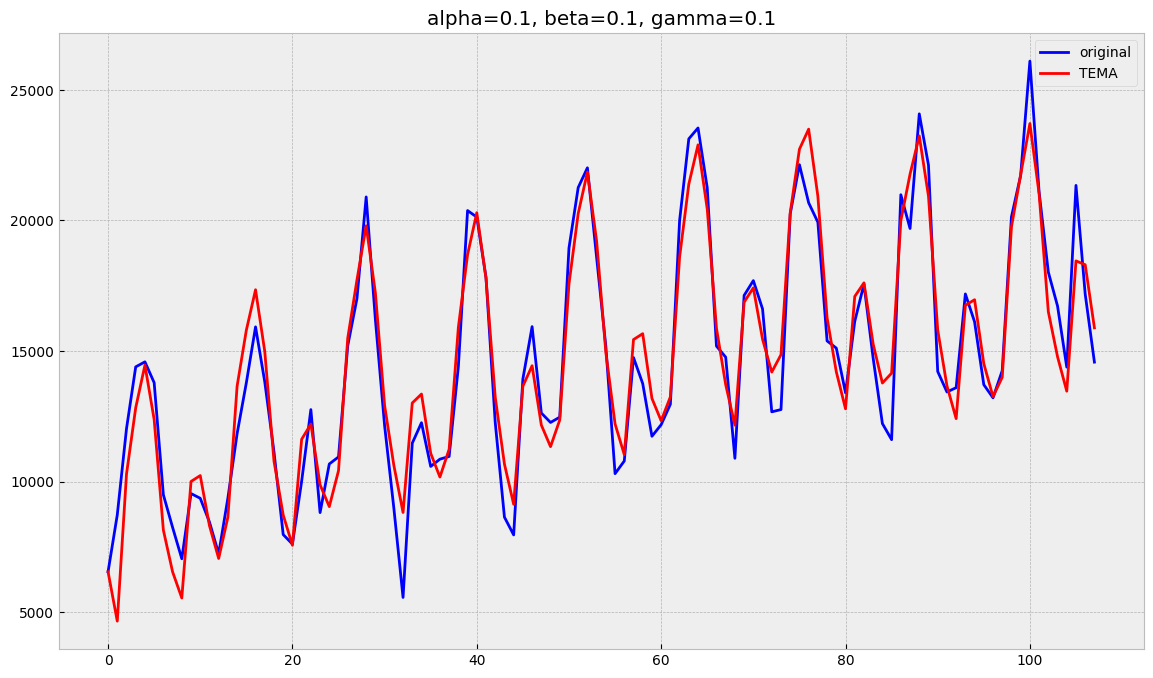

In [172]:
plot_tema(0.1, 0.1, 0.1, n_preds=0)

Подберем оптимальные параметры для модели Хольта-Винтерса

In [120]:
from scipy.optimize import minimize

In [192]:
train, test, val = original_series[:50], original_series[50:80], original_series[80:]

In [193]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [194]:
opt = minimize(mse, x0=[0,0,0], method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

In [195]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(alpha_opt, beta_opt, gamma_opt)

0.34197916262001915 0.2126816752527726 0.560122370966004


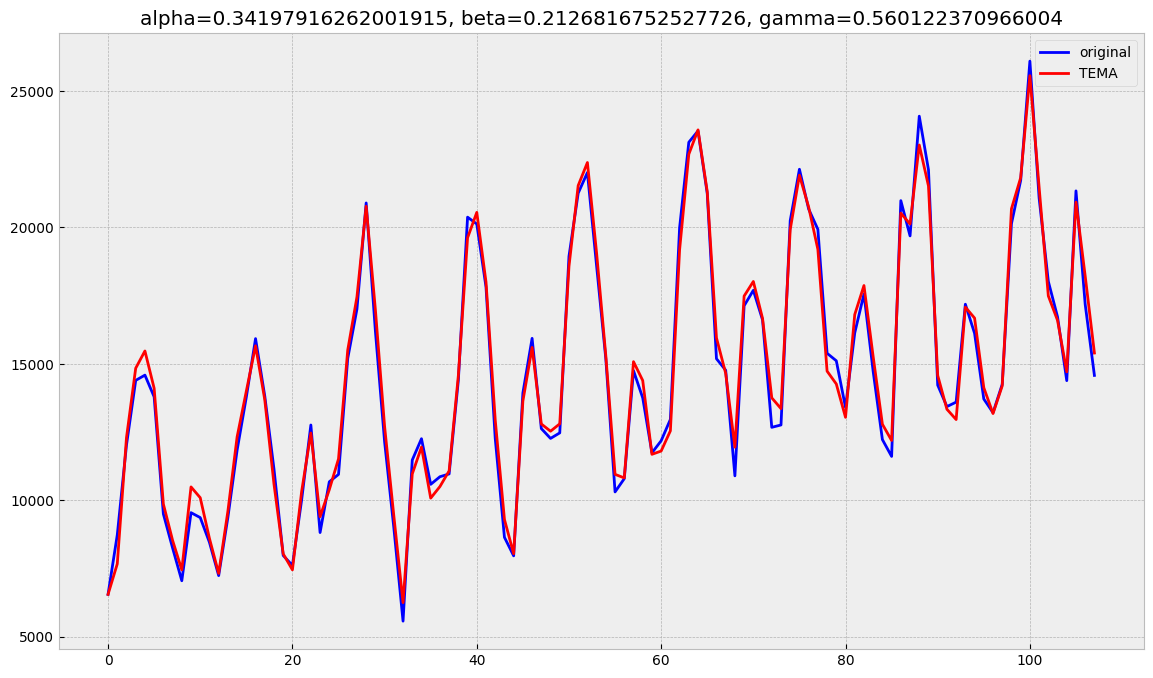

In [196]:
plot_tema(alpha_opt, beta_opt, gamma_opt, n_preds=0)

In [201]:
RMSE_TEMA = mean_squared_error(original_series, triple_exponential_smoothing(
    original_series, 12, alpha_opt, beta_opt, gamma_opt, n_preds=0), squared = False)
RMSE_TEMA

491.92341968871233

График функции TEMA достаточно точно повторяет исходный временной ряд, что также подтверждается относительно небольшим значением метрики RMSE.

**Вывод:** 
Поскольку стационарный ряд по определению не содержит тренда и сезонности, такие методы как DEMA и TEMA в данном случае применять не имеет смысла, поэтому для решения поставленной задачи применялись методы MA, WMA, EMA. Среди выбранных методов лучший результат показал метод WMA, который смог более точно апроксимировать амплитуду колебаний стационарного ряда.

Для не стационарного ряда был применен метод TEMA, т.к. данный метод лучше подходит для временных рядов имеющих тренд и сезонность, а нам было изначально известно что наш ряд содержит указанные компоненты. Указанный метод показал достаточно хорошие результаты, ориентируясь на относительно небольшое значение метрики RMSE.